# <center>  Notebook S12. FORTRAN API </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demonstrates how to use external FORTRAN code to compute the convolution matrix. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify interpretation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

In [1]:
using Plots, Plots.PlotMeasures, DataFrames, DifferentialMobilityAnalyzers
plotlyjs();   

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Compute Convolution Matrix For DMA δ
δ.Ω is defined in src/dmafunctions.jl and includes diffusional broadening. Alternative functions for Ω can easily be either added to the package or defined and passed to the T = ... statement

In [2]:
t,p = 296.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 128, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices internally

T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp); 
@time 𝐀₁ = (hcat(map(zˢ->Σ(k->T(zˢ,k,Λ,δ),Λ.m),δ.Z)...))'; # compute matrix explicitly, 𝐀₁ == δ.A

  1.374549 seconds (8.50 M allocations: 257.071 MiB, 4.55% gc time)


## Direct Call of FORTRAN Function 
Instead of defining alterante formulations of Ω in Julia, existing FORTRAN (or C) code can be called directly from Julia. This enables seamless integration of numerically derived transfer functions, e.g. through Monte-Carlo analysis, with the DMA language described in this work. A step-by-step tutorial with a simple example is provided.

### 1. Write/Inspect FUNCTION
The Knutson and Whitby (1975) transfer function.

<center> 
    $\Omega(Z,z^s,\beta) = \begin{cases} \frac{1}{2\beta}\left(
     \left | \frac{z^s}{Z}-(1+\beta) \right |
     + \left | \frac{z^s}{Z}-(1-\beta) \right |
     -2 \left | \frac{z^s}{Z}-1 \right |\right), z^s \in [(1-\beta)Z, (1+\beta)Z]\\ 0, \mathrm{otherwise} \end{cases} $
     </center> 
     
is implementd in FORTRAN in file _omega.f_ 
<img src="Figures/nbs12_f01.png" width="450">

### 2. Create Shared Library 
Example compile call using the GNU Fortran compiler (https://gcc.gnu.org/fortran/) from the Linux command line <br>
```gfortran -Wall -shared -o extlib.so -fPIC omega.f``` <br>

The FORTRAN compiler mangles the function name (https://en.wikipedia.org/wiki/Name_mangling). To obtain the function name in the library, the GNU nm tool (https://en.wikipedia.org/wiki/Nm_(Unix)) can be used <br>
```nm extlib.so```

which reveals the mangled function name omega_

### 3. Call Function Using ccall
```julia
ccall(
    (:omega_,"extlib.so"),     # (function,library) tuple
    Float32,                   # Return data type
    (Ref{Float32},Ref{Float32},Ref{Float32}),  # Input data types for  Z, ZS, BETA
    z,zˢ,β                     # Pass Julia Variables z, zˢ, β to FORTRAN routine by reference
) 
```
Note that type equivalents (FORTRAN REAL = Julia Float32) are critical. See Julia documentation (https://docs.julialang.org/en/stable/manual/calling-c-and-fortran-code/) for type equivalents.

Finally, FORTRAN omega.f is written for a scalar, to make it work for arrays the ccall is wrapped in a simple function. 
```julia
Ωext = (Z,zˢ) -> map(z -> Ωccall(z,zˢ,β), Z)
```

Now Ωext(Z,zˢ) is structurally equivalent to the package internal call δ.Ω(Z,zˢ)

In [3]:
push!(Base.DL_LOAD_PATH,"FORTRAN/")  # Add FORTRAN directory to the library load path
function Ωccall(z,zˢ,β)               # Wrapper for ccall
   return ccall((:omega_,"extlib.so"), Float32,(Ref{Float32},Ref{Float32},Ref{Float32}), z,zˢ,β)
end
Ωext = (Z,zˢ) -> map(z -> Ωccall(z,zˢ,β), Z);

## Compute Matrix With FORTRAN Transfer Function

In [4]:
T = (zˢ,k,Λ,δ) -> Ωext(δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp); 
@time 𝐀₂ = (hcat(map(zˢ->Σ(k->T(zˢ,k,Λ,δ),Λ.m),δ.Z)...))';

  0.297007 seconds (1.07 M allocations: 56.431 MiB, 5.23% gc time)


## Compare Results
Note that the plot is the same as in Notebook S2.

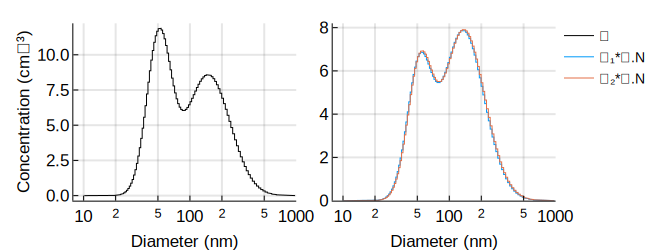

In [5]:
𝕟 = DMALognormalDistribution([[230, 50, 1.3], [280, 140, 1.6]],δ)
figure("Nimbus Sans L", 2, 4.5, 1.75, 8)
p1 = plot(𝕟.Dp, 𝕟.N, xaxis = :log10, xticks = [10, 100, 1000], left_margin = 15px, label = "𝕟",
    ylabel = "Concentration (cm⁻³)", xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)", 
    lt = :steppre)

p2 = plot(𝕟.Dp, 𝐀₁*𝕟.N, xaxis = :log10, left_margin = 25px, lt = :steppre,ylim = (0,8.2),
     xlim = (8,1000), xlabel = "Diameter (nm)", label = "𝐀₁*𝕟.N")

p2 = plot!(𝕟.Dp, 𝐀₂*𝕟.N, lt = :steppre, label = "𝐀₂*𝕟.N")

plot(p1,p2,grid=(1,2), fmt = :svg)

__Figure 1.__ The two models do not exactly agree. This is because Ωext and δ.Ω(Z,zˢ) are different models of the transfer function. δ.Ω(Z,zˢ) includes diffusional broadening. 

## References
Knutson, E. O. & K. T. Whitby (1975) Aerosol classification by electric mobility: Apparatus, theory, and applications. J. Aerosol Sci. (6)443-451, DOI:10.1016/0021-8502(75)90060-9